In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib notebook

import pickle
from astropy.io import fits
import bz2

In [3]:
science_list = np.genfromtxt("science.list", dtype = str)

In [4]:
science_first = pickle.load(bz2.BZ2File("science_corr/" + science_list[0][:-5] + "_corr.bz2", "rb"))

<IPython.core.display.Javascript object>


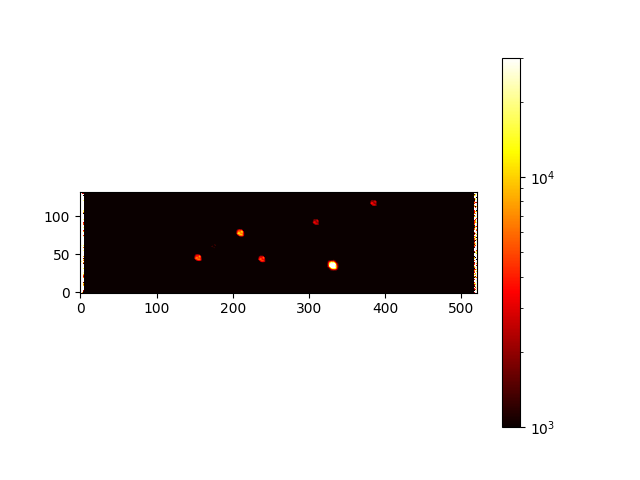

In [5]:
fig, ax = plt.subplots(1,1)
im1 = plt.imshow(science_first, origin = "lower", cmap = plt.cm.get_cmap("hot"), norm = colors.LogNorm(vmin = 1000, vmax = 30000))
plt.colorbar(im1)
plt.show()

In [6]:
#Position of the star WASP-135: x=238, y=44 in pixels (from Simbad library)

#In order to perform differential photometry, we also need some reference stars.
#Ref stars must have similar intensity to the target star, and must not saturate the CCD.
#Ref 1: x=154, y=46
#Ref 2: x=210, y=78
#Ref 3: x=309, y=92
#Ref 4: x=384, y=117

In [33]:
x_target, y_target = 238, 44
x_ref1, y_ref1 = 154, 46
x_ref2, y_ref2 = 210, 78
x_ref3, y_ref3 = 309, 93
x_ref4, y_ref4 = 384, 117

inner_radius = 8
outer_radius = 20

<IPython.core.display.Javascript object>


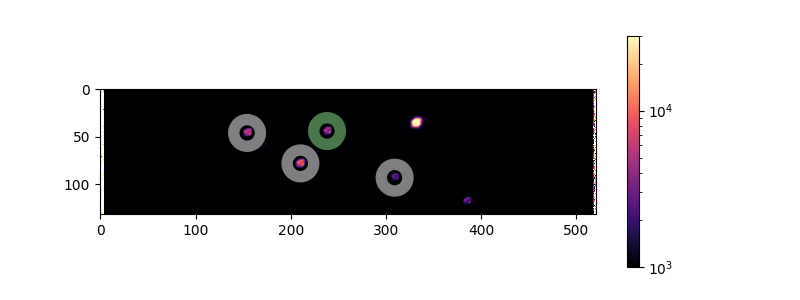

In [35]:
fig, ax = plt.subplots(1, figsize=(8,3))
im = plt.imshow(science_first,
                 cmap = plt.cm.get_cmap("magma"),
                 norm = colors.LogNorm(vmin = 1000, vmax = 30000))

n, radii = 50, [inner_radius, outer_radius]
theta = np.linspace(0, 2*np.pi, n, endpoint=True)
xs = np.outer(radii, np.cos(theta))
ys = np.outer(radii, np.sin(theta))

xs[1,:] = xs[1,::-1]
ys[1,:] = ys[1,::-1]

ax.fill(np.ravel(xs)+x_target, np.ravel(ys)+y_target,
        edgecolor=None, facecolor='lightgreen', alpha=0.5)

ax.fill(np.ravel(xs)+x_ref1, np.ravel(ys)+y_ref1,
        edgecolor=None, facecolor='white', alpha=0.5)

ax.fill(np.ravel(xs)+x_ref2, np.ravel(ys)+y_ref2,
        edgecolor=None, facecolor='white', alpha=0.5)

ax.fill(np.ravel(xs)+x_ref3, np.ravel(ys)+y_ref3,
        edgecolor=None, facecolor='white', alpha=0.5)

plt.colorbar(im)
plt.show()

Aperture photometry showing the central circular aperture and the annulus, or ring, surrounding it and used to subtract the background. The average count from pixels in this ring is subtracted from each pixel in the central zone, leaving only the values for the brightness of the star itself.

In [45]:
#This is a non-optimized way, pretty slow (>3 mins with 1000 images)

import time
t0 = time.time()

rr = np.zeros_like(science_first)
for y1 in range(0, np.shape(science_first)[0]):
    for x1 in range(0, np.shape(science_first)[1]):
        rr[y1, x1] = np.sqrt((x1-x_target)**2 + (y1-y_target)**2)
        
t1 = time.time()
print('time required: ', t1-t0)

time required:  0.1272592544555664


In [48]:
#This is a better method (about 3 seconds with 1000 images)

import time
t0 = time.time()

y = np.arange(0, np.shape(science_first)[0])
x = np.arange(0, np.shape(science_first)[1])
xx, yy = np.meshgrid(x, y)

rr = np.sqrt((xx-x_target)**2 + (yy-y_target)**2)
t1 = time.time()
print('time required: ', t1-t0)

time required:  0.003930091857910156


In [51]:
#Centroid algorithm

inner_radius = 8
annulus_selection = (rr < inner_radius)
flux = np.sum(science_first[annulus_selection])
wx = np.sum(science_first[annulus_selection] * xx[annulus_selection])
wy = np.sum(science_first[annulus_selection] * yy[annulus_selection])

x_target_refined = wx/flux
y_target_refined = wy/flux

print('Refined coordinates of the target star: x = {0:5.2f}, y = {1:5.2f}'.format(
    x_target_refined, y_target_refined))

Refined coordinates of the target star: x = 238.14, y = 43.94


In [52]:
target_inner_radius = 8
target_outer_radius = 20

rr = np.sqrt((xx-x_target_refined)**2 + (yy-y_target_refined)**2)
sky_annulus = (rr > target_inner_radius) & (rr < target_outer_radius)

sky_flux = np.sum(science_first[sky_annulus])/np.sum(sky_annulus)
print('Sky flux: {0:7.1f} photoelectrons/pixel'.format(sky_flux))

Sky flux:   485.9 photoelectrons/pixel


<IPython.core.display.Javascript object>


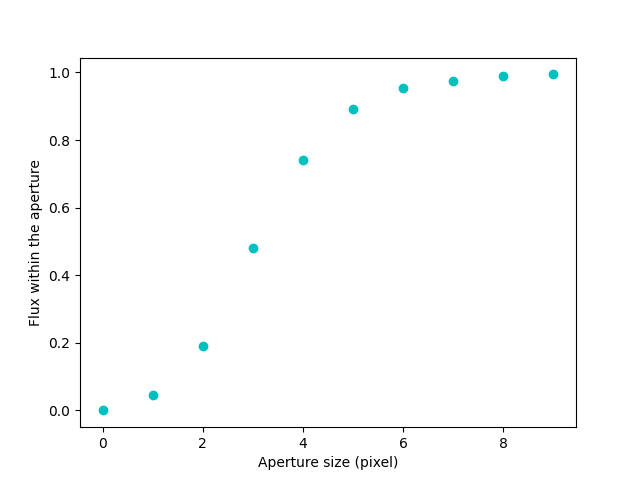

In [58]:
science_corrected = science_first - sky_flux
plt.figure()

largest_aperture = (rr < 10)
maximum_flux = np.sum(science_corrected[largest_aperture])

for ii in range(0,10):
    aperture_selection = (rr < ii)
    aperture_flux = np.sum(science_corrected[aperture_selection]) / maximum_flux
    plt.scatter(ii, aperture_flux, c='c')

plt.xlabel('Aperture size (pixel)')
plt.ylabel('Flux within the aperture')
plt.show()